<a href="https://www.kaggle.com/code/adrianacosta0/cnn-for-images-of-nanoscale-sem-features?scriptVersionId=157354268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

import os

## File structure

In [2]:
def print_directory_structure(path):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        # The files are not printed, only the directory names

# Path to the directory you want to check
directory_path = '/kaggle/input/'

# Print the folder structure
print_directory_structure(directory_path)


/
sem-images-of-nanoscale-features/
    Particles/
        Particles/
    Powder/
        Powder/
    Biological/
        Biological/
    Nanowires/
        Nanowires/
    Porous_Sponge/
        Porous_Sponge/
    MEMS_devices_and_electrodes/
        MEMS_devices_and_electrodes/
    Films_Coated_Surface/
        Films_Coated_Surface/
    Fibres/
        Fibres/
    Patterned_surface/
        Patterned_surface/
    Tips/
        Tips/
wiki-sem-images/


## Import libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import shutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load and pre-process data

In [4]:
original_data_dir = '/kaggle/input/sem-images-of-nanoscale-features/'
base_dir = '/kaggle/working/split_sem_images/'  # Adjusted to a writable directory
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [5]:
categories = ['Particles', 'Powder', 'Biological', 'Nanowires', 'Porous_Sponge', 
              'MEMS_devices_and_electrodes', 'Films_Coated_Surface', 'Fibres', 
              'Patterned_surface', 'Tips']

In [6]:
for category in categories:
    category_dir = os.path.join(original_data_dir, category, category)
    files = os.listdir(category_dir)
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    # Create category-specific directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Copy files to their respective directories
    for file in train_files:
        shutil.copy(os.path.join(category_dir, file), os.path.join(train_dir, category))
    for file in val_files:
        shutil.copy(os.path.join(category_dir, file), os.path.join(val_dir, category))
    for file in test_files:
        shutil.copy(os.path.join(category_dir, file), os.path.join(test_dir, category))


In [7]:
data_dir = '/kaggle/input/sem-images-of-nanoscale-features/'
batch_size = 32
img_height = 614
img_width = 1024

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 13000 images belonging to 10 classes.
Found 2786 images belonging to 10 classes.
Found 2791 images belonging to 10 classes.


## Load the Pre-Trained InceptionV3 Model:

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 0s 0us/step


## Compile the model

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Model

In [10]:
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs)

Epoch 1/10
406/406 [==============================] - 380s 895ms/step - loss: 0.5901 - accuracy: 0.8037 - val_loss: 0.3860 - val_accuracy: 0.8675
Epoch 2/10
406/406 [==============================] - 362s 892ms/step - loss: 0.3698 - accuracy: 0.8731 - val_loss: 0.3781 - val_accuracy: 0.8703
Epoch 3/10
406/406 [==============================] - 371s 914ms/step - loss: 0.2943 - accuracy: 0.8984 - val_loss: 0.3951 - val_accuracy: 0.8649
Epoch 4/10
406/406 [==============================] - 378s 930ms/step - loss: 0.2466 - accuracy: 0.9130 - val_loss: 0.2808 - val_accuracy: 0.9041
Epoch 5/10
406/406 [==============================] - 372s 915ms/step - loss: 0.2112 - accuracy: 0.9262 - val_loss: 0.2569 - val_accuracy: 0.9142
Epoch 6/10
406/406 [==============================] - 376s 926ms/step - loss: 0.1814 - accuracy: 0.9363 - val_loss: 0.2403 - val_accuracy: 0.9181
Epoch 7/10
406/406 [==============================] - 376s 925ms/step - loss: 0.1712 - accuracy: 0.9396 - val_loss: 0.3225 -

## Print the class labels

In [11]:
class_labels = train_generator.class_indices
print(class_labels)

{'Biological': 0, 'Fibres': 1, 'Films_Coated_Surface': 2, 'MEMS_devices_and_electrodes': 3, 'Nanowires': 4, 'Particles': 5, 'Patterned_surface': 6, 'Porous_Sponge': 7, 'Powder': 8, 'Tips': 9}


## Save the model

In [12]:
model.save('/kaggle/working/model.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model.save('/kaggle/working/model.keras')

In [14]:
# To load the model later
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5')

## Evaluate model performance

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)


88/88 [==============================] - 69s 776ms/step - loss: 0.2442 - accuracy: 0.9212
Test loss:  0.24421095848083496
Test accuracy:  0.9211751818656921


## Confusion Matrix
This shows the model's predictions versus the actual labels, helping identify which classes are being confused by the model.

88/88 [==============================] - 66s 735ms/step


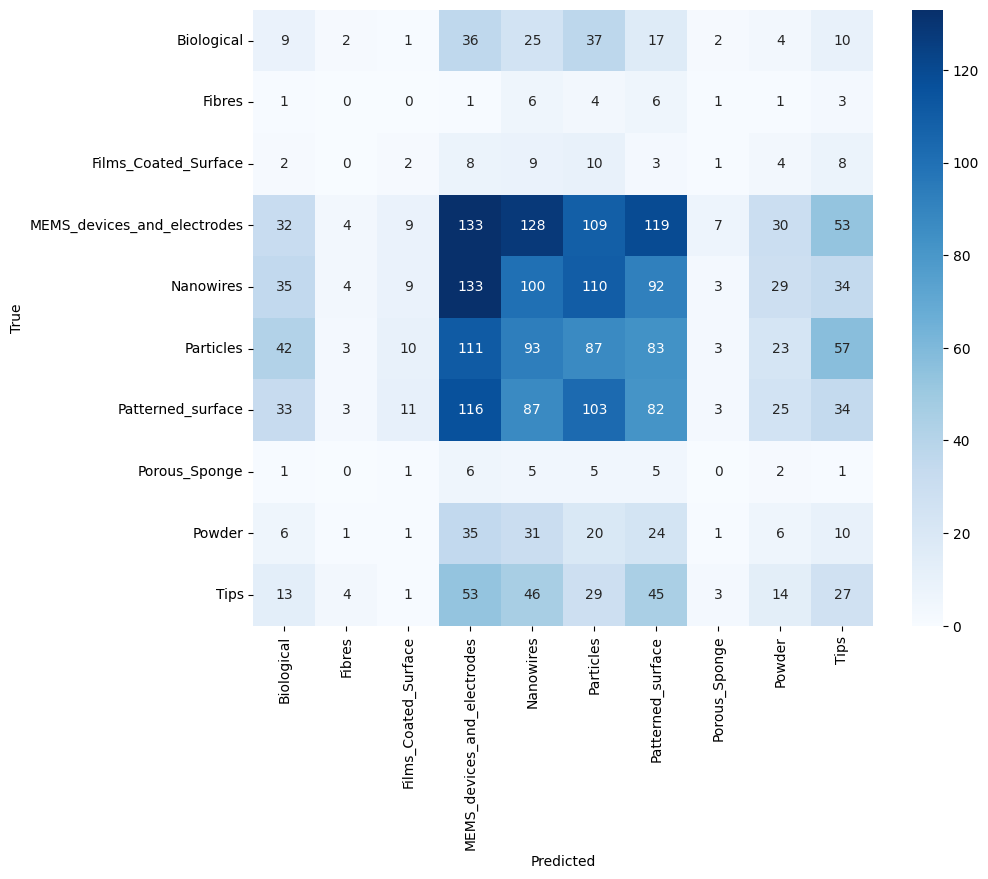

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the values from the test dataset
test_predictions = model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Classification Report

Provides a breakdown of precision, recall, and F1-score for each class.

In [17]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=class_labels))


                             precision    recall  f1-score   support

                 Biological       0.05      0.06      0.06       143
                     Fibres       0.00      0.00      0.00        23
       Films_Coated_Surface       0.04      0.04      0.04        47
MEMS_devices_and_electrodes       0.21      0.21      0.21       624
                  Nanowires       0.19      0.18      0.19       549
                  Particles       0.17      0.17      0.17       512
          Patterned_surface       0.17      0.16      0.17       497
              Porous_Sponge       0.00      0.00      0.00        26
                     Powder       0.04      0.04      0.04       135
                       Tips       0.11      0.11      0.11       235

                   accuracy                           0.16      2791
                  macro avg       0.10      0.10      0.10      2791
               weighted avg       0.16      0.16      0.16      2791



## Learning Curves
Plot the training and validation accuracy and loss to understand if the model is learning effectively.

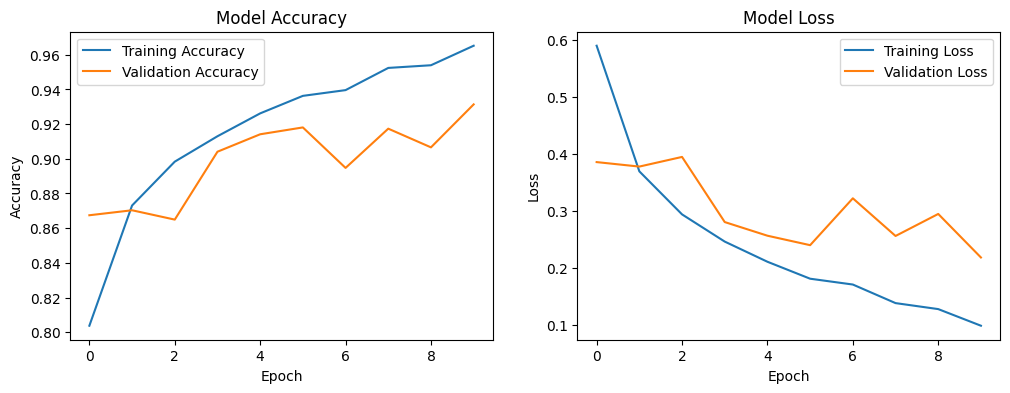

In [18]:
# Assuming `history` is the history object returned by the `model.fit()` method you ran earlier
plt.figure(figsize=(12, 4))

# Plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


## Testing on random SEM images from a different dataset
(so as to be less biased that the images don't come from the same curated source used for training/validation and prior testing)

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import plotly.express as px
import numpy as np

In [20]:
def predict_image(image_path, model, target_height, target_width):
    # Load and resize the image
    img = load_img(image_path, target_size=(target_height, target_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make a prediction
    prediction = model.predict(img_array)
    top_3_classes = np.argsort(prediction[0])[-3:][::-1]  # Get indices of top 3 classes
    top_3_confidences = np.sort(prediction[0])[-3:][::-1]  # Get confidences of top 3 classes
    return top_3_classes, top_3_confidences

def predict_and_visualize(image_path, loaded_model, target_height, target_width):
  
    top_3_classes, top_3_confidences = predict_image(image_path, loaded_model, target_height, target_width)
    
    # Load and display the image
    img = mpimg.imread(image_path)
    img = img[..., :3]  # Keep only the first three channels (RGB)
    img_resized = tf.image.resize(img, [target_height, target_width])
    img_resized = img_resized / tf.reduce_max(img_resized)  # Rescale pixel values to the range [0, 1]
    
    plt.imshow(img_resized)
    plt.axis('off')
    
    class_names = {0: 'Biological', 1: 'Fibres', 2: 'Films_Coated_Surface', 3: 'MEMS_devices_and_electrodes', 4: 'Nanowires', 5: 'Particles', 6: 'Patterned_surface', 7: 'Porous_Sponge', 8: 'Powder', 9: 'Tips'}

    class_name_1 = class_names[top_3_classes[0]]
    class_name_2 = class_names[top_3_classes[1]]
    plt.title(f'Best Guess: {class_name_1}, Confidence: {top_3_confidences[0]:.2f}\n'
              f'Second Best Guess: {class_name_2}, Confidence: {top_3_confidences[1]:.2f}')
    plt.show()

1/1 [==============================] - 2s 2s/step


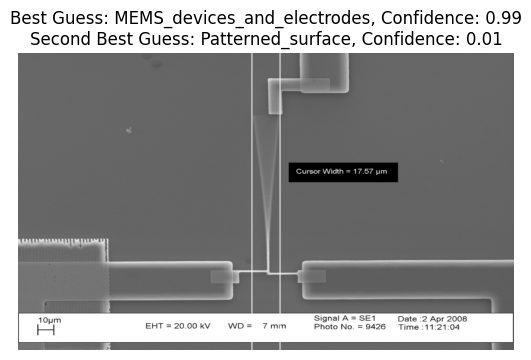

In [21]:
image_path = '/kaggle/input/wiki-sem-images/1280px-MEMS_Microcantilever_in_Resonance.png' # I pulled this from a completely different data source: https://en.wikipedia.org/wiki/MEMS#/media/File:MEMS_Microcantilever_in_Resonance.png
predict_and_visualize(image_path, loaded_model, 614, 1024)

1/1 [==============================] - 0s 36ms/step


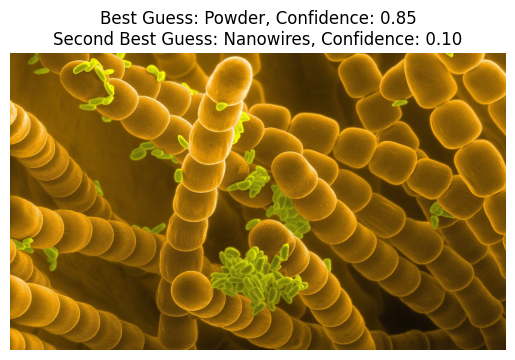

In [22]:
image_path = '/kaggle/input/wiki-sem-images/1920px-Tradescantia_tolmukakarvad_ja_ietolm.png' # https://en.wikipedia.org/wiki/File:SARS-CoV-2_scanning_electron_microscope_image.jpg
predict_and_visualize(image_path, loaded_model, 614, 1024) ## this is biological but we can see how it could think its particles and nanowires

1/1 [==============================] - 0s 30ms/step


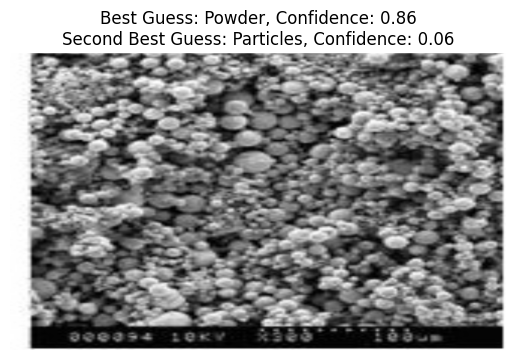

In [23]:
image_path = '/kaggle/input/wiki-sem-images/Flaky_interlocking_rhenium_powder.png' # https://en.m.wikipedia.org/wiki/File:Flaky_interlocking_rhenium_powder.jpg
predict_and_visualize(image_path, loaded_model, 614, 1024)

1/1 [==============================] - 0s 33ms/step


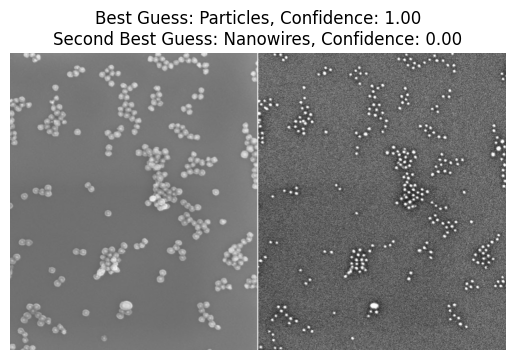

In [24]:
image_path = '/kaggle/input/wiki-sem-images/REM-Bsp-3a.png' # https://www.igb.fraunhofer.de/en/analysis-and-testing-services/surface-analytics/surface-analytics/sem-edx.html
predict_and_visualize(image_path, loaded_model, 614, 1024)

1/1 [==============================] - 0s 31ms/step


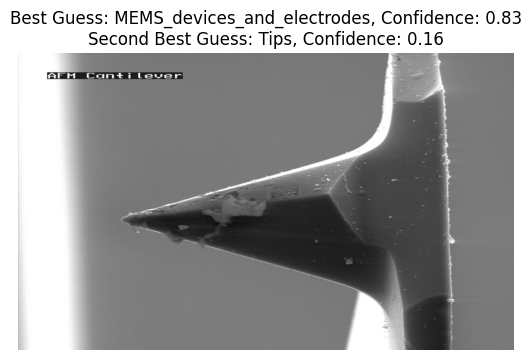

In [25]:
image_path = '/kaggle/input/wiki-sem-images/AFM_(used)_cantilever_in_Scanning_Electron_Microscope_magnification_3000x.png' # https://en.wikipedia.org/wiki/Atomic_force_microscopy#/media/File:AFM_(used)_cantilever_in_Scanning_Electron_Microscope,_magnification_3000x.JPG
predict_and_visualize(image_path, loaded_model, 614, 1024)